In [14]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import os
import re
import cv2
from google.cloud import vision_v1p3beta1 as vision
import pandas as pd

In [15]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [16]:
def recognise_license_plate(img):

    height, width = img.shape[:2]
    img_scale = cv2.resize(img, (800, int((height*800)/width)))

    client = vision.ImageAnnotatorClient()

    err, arr = cv2.imencode(".png", img_scale)
    content = arr.tobytes()

    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    texts = [text.description for text in texts]
    licenses = []

    for text in texts[0].split('\n'):
        text = text.strip().replace(" ", "")
        result = re.search(r"^[A-Z0-9]{6,7}$", text)
        if result:
            #print(f"match: {result.group()}")
            licenses.append(result.group())
        else:
            #print(f"no match: {text}")
            pass

    return licenses

In [17]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [18]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


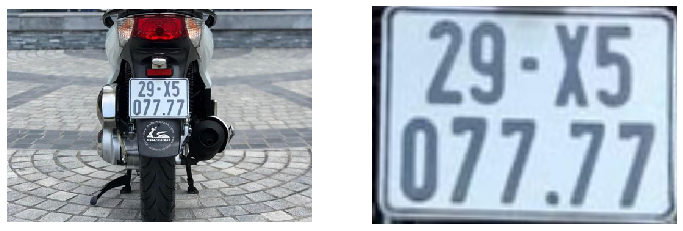

In [110]:
#  Plate_examples/usa_car_plate.jpg
#test_image_path = "test_2.jpg"
test_image_path = "Plate_examples/vietnam_motor_plate.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])


In [105]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'platesniper-544c99078427.json'

plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

img1 = "Plate_examples/american2.jpg"
temp = cv2.imread(img1)
PlateNum = recognise_license_plate(plate_image)
lTS = ' '.join([str(elem) for elem in PlateNum]) 
print(lTS)

DAL8KRZ


In [106]:
def autonation_service(lTS):
    Users_df = pd.read_csv("Users.csv")
    if lTS in Users_df.values:
        activeDF = Users_df[Users_df.LP == lTS]
        if not activeDF["Time_Slot"].isnull().sum() > 1:
            print(activeDF.Name.to_string(index=False) + " has a meeting at"+ activeDF.Time_Slot.to_string(index=False) + " with"+  activeDF.Representitive.to_string(index=False))
        else:
            print(activeDF.Name.to_string(index=False) + " does not have a meeting today. ")
    else:
        print("Unknown User, with licesnse plate number: "+ lTS + " has arrived. ")

In [107]:
autonation_service(lTS)

Unknown User, with licesnse plate number: DAL8KRZ has arrived. 


In [108]:
def Home_service(lTS):
    Home_df = pd.read_csv("Home.csv")
    
    if lTS in Home_df.values:
        activeDF2 = Home_df[Home_df.LP == lTS]
        print(activeDF2.Name.to_string(index=False) + " is arriving Home")
        print(" Lights:" + activeDF2.Lights.to_string(index=False))
        print(" Garage:" + activeDF2.Garage.to_string(index=False))
        print(" Temperature set to:" + activeDF2.Temp.to_string(index=False))
        print(" Music:" + activeDF2.Music.to_string(index=False))
        print(" Front Door:" + activeDF2.Door_Lock.to_string(index=False))
    else:
        print(lTS +" does not belong to a member of this household. ")



In [109]:
Home_service(lTS)

 Charlie is arriving Home
 Lights: Off
 Garage: Close
 Temperature set to: 80
 Music: On
 Front Door: unlock
